## This version uses the correct matrices in the linear equation. It however seems to give nearly indentical results to my previous version.

In [96]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [97]:
x = np.arange(-16, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

In [98]:
import scipy.stats

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = scipy.stats.multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

#g1 = gaussian2d(grid) + gaussian2d(grid, [5,5], [3,1])
#plt.imshow(g1)

Make the two "images". `im1` is the template, `im2` is the science image.

NOTE: having sources near the edges really messes up the fitting (probably because of the convolution). So make sure no sources are near the edge.

NOTE: also it seems that having the variable source with a large flux increase also messes up the fitting (seems to lead to overfitting -- perhaps to the source itself). This might be fixed by adding more constant sources.

280 -0.688220756087 -11.6171994264
DescribeResult(nobs=262144, minmax=(-1358.231240709586, 415.11445987856109), mean=-1.9102230795921878e-05, variance=3058.5064469891863, skewness=-9.101008686155017, kurtosis=128.06319735703448)


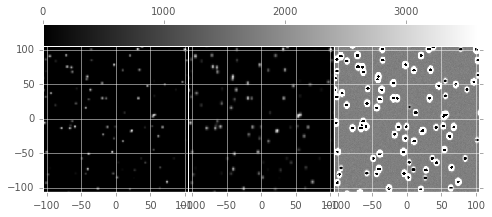

In [99]:
np.random.seed(66)

xim = np.arange(-256, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))
n_sources = 500
fluxes = np.random.uniform(50, 30000, n_sources)
xposns = np.random.uniform(xim.min()+5, xim.max()-5, n_sources)
yposns = np.random.uniform(yim.min()+5, yim.max()-5, n_sources)

# Make the source closest to the center of the image the one that increases in flux
ind = np.argmin(xposns**2. + yposns**2.)
print ind, xposns[ind], yposns[ind]

sig1 = 0.2  # sigma of template
sig2 = 0.2  # sigma of science image
im1 = np.random.normal(scale=sig1, size=x0im.shape)
im2 = np.random.normal(scale=sig2, size=x0im.shape)

psf1 = 1.6 # sigma in pixels im1 will be template
psf2 = 2.2 # sigma in pixels im2 will be science image. make the psf in this image slighly offset and elongated
offset = 0.0  # 0.2  # astrometric offset in pixels between two images
for i in range(n_sources):
    im1 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i],yposns[i]], s=[psf1, psf1])
    im2 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i]+offset,yposns[i]+offset], s=[psf2, psf2*1.5])
    if i == ind:
        im2 += (fluxes[i]/50.) * gaussian2d(imgrid, m=[xposns[i]+offset,yposns[i]+offset], s=[psf2, psf2*1.5])

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (9, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow((im2-im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10))
igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - im1, axis=None)

## Compute the FFTs for the "ZOGY" algorithm

In [100]:
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift

DescribeResult(nobs=262144, minmax=(-0.92719462140093301, 3706.1292894132293), mean=28.094248003911815, variance=27655.067390995864, skewness=8.92762151923837, kurtosis=95.88840882524867)
DescribeResult(nobs=262144, minmax=(-0.92719462140096698, 3706.1292894132289), mean=28.094248003911815, variance=27655.067390995864, skewness=8.927621519238366, kurtosis=95.88840882524867)


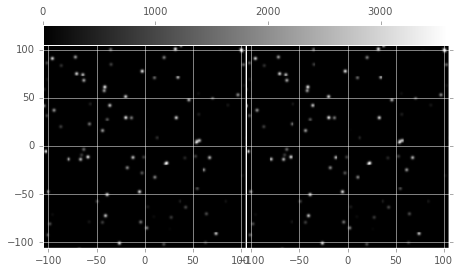

In [101]:
# First compute the science image's (im2's) psf -- easy since we parameterized it above when we made the image
im1_psf = gaussian2d(grid, m=[0, 0], s=[psf1, psf1])
im2_psf = gaussian2d(grid, m=[0, 0], s=[psf2, psf2*1.5])

im1_psf_ft = fft2(im1_psf)
im2_psf_ft = fft2(im2_psf)

im1_ft = fft2(im1)
im2_ft = fft2(im2)

# Just a sanity check:
fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(ifft2(im1_ft).real[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im1, axis=None)
print scipy.stats.describe(ifft2(im1_ft).real, axis=None)

### Now compute the ZOGY eqn. (13):

$$
\widehat{D} = \frac{F_r\widehat{P_r}\widehat{N} - F_n\widehat{P_n}\widehat{R}}{\sqrt{\sigma_n^2 F_r^2 |\widehat{P_r}|^2 + \sigma_r^2 F_n^2 |\widehat{P_n}|^2}}
$$

where $D$ is the optimal difference image, $R$ and $N$ are the reference and "new" image, respectively, $P_r$ and $P_n$ are their PSFs, $F_r$ and $F_n$ are their flux-based zero-points (which we will set to one here), $\sigma_r^2$ and $\sigma_n^2$ are their variance, and $\widehat{D}$ denotes the FT of $D$.

DescribeResult(nobs=262144, minmax=(-11.014876078693419, 35.438382855842292), mean=-6.7536577015931114e-05, variance=1.0395047182447847, skewness=0.9014126146296582, kurtosis=25.1438579147296)


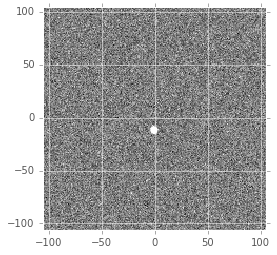

In [102]:
F_r = F_n = 1.
R_hat = fft2(im1)
N_hat = fft2(im2)
P_r = gaussian2d(imgrid, m=[0, 0], s=[psf1, psf1])
P_n = gaussian2d(imgrid, m=[0, 0], s=[psf2, psf2*1.5])
P_r_hat = fft2(P_r)
P_n_hat = fft2(P_n)
d_hat_numerator = (F_r * P_r_hat * N_hat - F_n * P_n_hat * R_hat)
d_hat_denom = np.sqrt((sig1**2 * F_r**2 * np.abs(P_r_hat)**2) + (sig2**2 * F_n**2 * np.abs(P_n_hat)**2))
d_hat = d_hat_numerator / d_hat_denom

d = ifft2(d_hat)
D = np.fft.ifftshift(d.real)
plt.imshow(D[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-4, 4))
print scipy.stats.describe(D, axis=None)

### Compute the PSF of the difference image D (eq. 14):

$$
\widehat{P_D} = \frac{F_r F_n \widehat{P_r} \widehat{P_n}}{F_D \sqrt{\sigma_n^2 F_r^2 |\widehat{P_r}|^2 + \sigma_r^2 F_n^2 |\widehat{P_n}|^2}}
$$

where

$$
F_D = \frac{F_r F_n}{\sqrt{\sigma_n^2 F_r^2 + \sigma_r^2 F_n^2}}
$$

DescribeResult(nobs=262144, minmax=(-0.00024047487788385883, 0.067636466953262503), mean=3.8146972656251474e-06, variance=1.3334160082545696e-07, skewness=124.37568288985155, kurtosis=17332.81542239945)


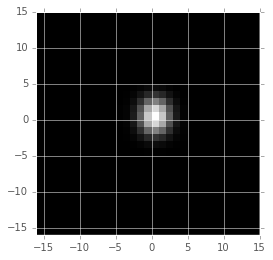

In [103]:
F_D_numerator = F_r * F_n
F_D_denom = np.sqrt(sig1**2 * F_r**2 + sig2**2 * F_n**2)
F_D = F_D_numerator / F_D_denom

P_d_hat_numerator = (F_r * F_n * P_r_hat * P_n_hat)
P_d_hat = P_d_hat_numerator / (F_D * d_hat_denom)

P_d = ifft2(P_d_hat)
P_D = np.fft.ifftshift(P_d.real)
extent = (x0im.min()+240, x0im.max()-240, y0im.min()+240, y0im.max()-240)
x1p, x2p, y1p, y2p = 240, 511-240, 240, 511-240   # limits for display
plt.imshow(P_D[x1p:x2p,y1p:y2p], origin='lower', interpolation='none', cmap='gray', extent=extent) #, clim=(0, 0.67))
print scipy.stats.describe(P_D, axis=None)

Dump the results for comparison with L(ZOGY) in notebook #13.

In [104]:
import cPickle
import gzip
cPickle.dump((im1, im2, im1_psf, im2_psf, D, P_D), gzip.GzipFile("12_results.p.gz", "wb"))

Compute two kernels to convolve im1 and im2 with -- then convolve in image space and subtract. Compare the results.

0.2 0.2 1.6 2.2
0.2 0.2 1.0 1.0
4.99999999956 3.53553390593 19256.9802411
(63, 63) (63, 63)
4.85184687354 -0.125134411314 3.53553390593
(31, 31)
(31, 31)


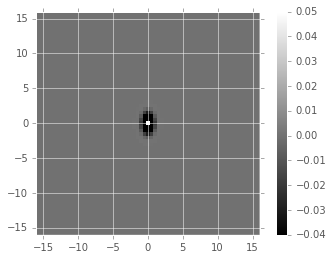

In [132]:
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift, ifftshift

# Note if we use a smaller PSF (e.g. 32x32) then we get artifacts in the convolution
x = np.arange(-31, 32, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

psf1 = 1.6 #* 5.
psf2 = 2.2 #* 5.
sig1 = sig2 = 0.2
F_r = F_n = 1.0
P_r = gaussian2d(grid, m=[0, 0], s=[psf1, psf1])
P_n = gaussian2d(grid, m=[0, 0], s=[psf2, psf2*1.5])
print sig1, sig2, psf1, psf2
print sig1, sig2, P_r.sum(), P_n.sum()
P_r_hat = fft2(P_r)
P_n_hat = fft2(P_n)
denom = np.sqrt((sig1**2 * F_r**2 * np.abs(P_r_hat)**2) + (sig2**2 * F_n**2 * np.abs(P_n_hat)**2))
K_r_hat = P_r_hat / denom
K_n_hat = P_n_hat / denom
print np.abs(K_r_hat).max(), np.abs(K_r_hat).min(), np.abs(K_r_hat).sum()
#K_r = np.fft.ifftshift(np.abs(ifft2(K_r_hat)).real)
#K_n = np.fft.ifftshift(np.abs(ifft2(K_n_hat)).real)
K_r = ifft2(K_r_hat).real
K_n = ifft2(K_n_hat).real

pck = K_r.real #ifftshift(K_n).real
print K_r.shape, pck.real.shape
print pck.max(), pck.min(), pck.sum()
print np.unravel_index(np.argmax(pck), pck.shape)
print np.unravel_index(np.argmax(P_r), P_r.shape)

extent = (-16, 16, -16, 16)
#x1p, x2p, y1p, y2p = 240, 511-240, 240, 511-240   # limits for display
plt.imshow(K_r.real, origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-0.04,0.05))
#plt.imshow(pck, origin='lower', interpolation='none', cmap='gray', extent=extent) #clim=(-0.04,0.05)
#plt.imshow(P_n, origin='lower', interpolation='none', cmap='gray', extent=extent) #clim=(-0.04,0.05)
#plt.imshow(np.abs(P_r_hat).real)
plt.colorbar()

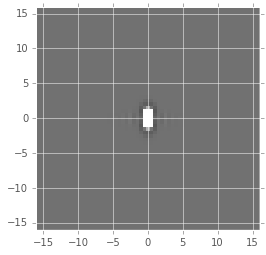

In [133]:
plt.imshow(K_n.real, origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-0.04,0.05))

DescribeResult(nobs=262144, minmax=(-4.4617303703618632, 35.438383396817244), mean=7.0906811821771186e-05, variance=1.0380693160912362, skewness=0.914853734914242, kurtosis=25.10469588989337)


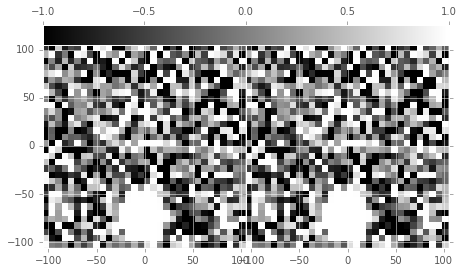

In [135]:
import scipy.ndimage.filters

tmp = K_n.real #[1:,1:]
im1c = scipy.ndimage.filters.convolve(im1, tmp, mode='constant')
tmp = K_r.real #[1:,1:]
im2c = scipy.ndimage.filters.convolve(im2, tmp, mode='constant')
diffim = im2c - im1c
print scipy.stats.describe(diffim, axis=None)

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
#x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
x1d, x2d, y1d, y2d = 240, 512-240, 240, 512-240   # limits for display
#plt.imshow(diffim[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-2.5,2.5)) # corrected diffim
gim = igrid[0].imshow(D[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1))
igrid[1].imshow(diffim[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1))
igrid.cbar_axes[0].colorbar(gim)

Compare the k-space vs. image-space versions:

-3.73715028169 3.73338010044
0.93487261423 0.934866295861
35.4383828558 35.4383833968
37.9071782791 37.9074350564
33 33


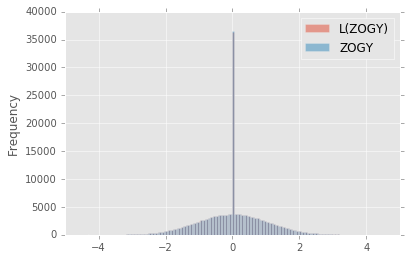

In [141]:
d1 = D
d2 = diffim
# The ZOGY diffim has artefacts on the edges. Let's set them to zero so they dont mess up the stats.
# The ZOGY(real) diffim has zero's at 32 pixels surrounding the image.
# Actually, let's just set the edge pixels of both diffims to zero.
d1[0:32,:] = d1[:,0:32] = d1[-1:32,:] = d1[:,-1:32] = 0.
d2[0:32,:] = d2[:,0:32] = d2[-1:32,:] = d2[:,-1:32] = 0.

import scipy.stats
_, low, upp = scipy.stats.sigmaclip([d1, d2])
print low, upp
low *= 1.1
upp *= 1.1
d1a = d1[(d1>low) & (d1<upp) & (d2>low) & (d2<upp)]
d2a = d2[(d1>low) & (d1<upp) & (d2>low) & (d2<upp)]
df = pd.DataFrame({'L(ZOGY)': d1a.flatten()/d1a.std(), 'ZOGY': d2a.flatten()/d2a.std()})
df.plot.hist(alpha=0.5, bins=200)

print d1a.std(), d2a.std()
print d1.max(), d2.max()
print d1.max()/d1a.std(), d2.max()/d2a.std()
print np.sum(d1>d1a.std()*5.), np.sum(d2>d2a.std()*5.)

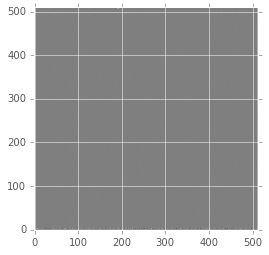

In [137]:
plt.imshow(d1 - d2, origin='lower', interpolation='none', cmap='gray', clim=(-0.1,0.1))

-0.753308093824 0.296270398402


(-0.002, 0.002)

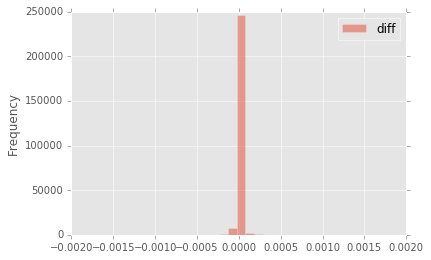

In [142]:
df = pd.DataFrame({'diff': (d1 - d2).flatten()})
df.plot.hist(alpha=0.5, bins=10000)
print df.min()[0], df.max()[0]
plt.xlim(-0.002, 0.002)